# Analysis of XPS spectra using ML algorithms

## Init

### Load necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.constants as constants
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from tqdm import trange
from PIL import Image
import os
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
import pandas as pd

In [15]:
path = '.'
data = f'{path}/data/'

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

### Useful functions

In [18]:
def dataLoader(data, batch_size = 128):
    N = 0
    L = data.shape[0]
    if type(data) == torch.Tensor:
        indices = torch.arange(0, L)
        permutations = torch.randperm(L)
        while N < L:
            inds = permutations[N:N+batch_size]
            N = N + batch_size
            yield data[inds, ], indices[inds]
    elif type(data) == np.ndarray:
        indices = np.arange(L)
        permutations = np.random.permutation(L)
        while N < L:
            inds = permutations[N:N+batch_size]
            N = N + batch_size
            yield data[inds, ], indices[inds]

# standard Alexnet image normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# loader with no shuffle
def Loader(data, batch_size=128, shuffle=False):
    N = 0
    L = data.shape[0]
    indices = np.arange(L)
    while N < L:
        inds = indices[N: N+batch_size]
        N = N + batch_size
        yield data[inds, ], inds

## Data preparation

In [19]:
tmp = np.load('data.npz')
structures = tmp['structures']
spectra = tmp['spectra']

(531.5, 539.0)

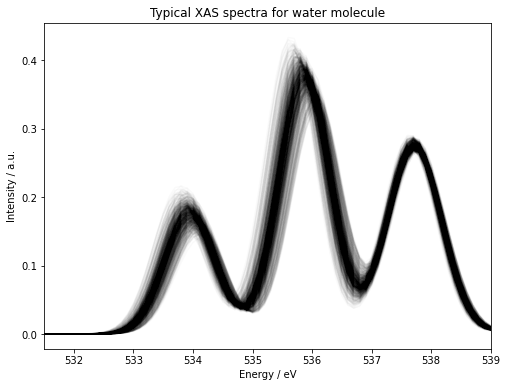

In [21]:
plt.rcParams['figure.figsize'] = (8,6)
fig = plt.figure()
plt.plot(z, spectra, c='k', alpha=0.02)
plt.xlabel('Energy / eV')
plt.ylabel('Intensity / a.u.')
plt.title('Typical XAS spectra for water molecule')
plt.xlim([531.5, 539])
#plt.savefig(f'{path}/figures/{name}_spectra_{N}.png',bbox_inches='tight', dpi=300)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.18it/s]


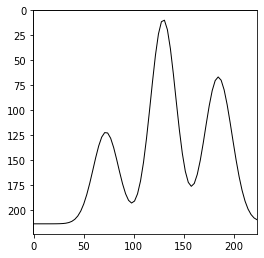

In [23]:
''' standard approach
- Create a figure with a size of (224/72)x(224/72) inches canvas
- Remove axis
- Plot the curve
- Export the image as PNG
- Load the PNG as the image
- Transform useing standard AlexNet data normalization procedure 
'''
N = len(structures)
images = torch.zeros((N, 3, 224, 224)).to(device)
plt.rcParams['figure.figsize'] = (224/72,224/72)
fig = plt.figure()
ax = fig.add_axes((0,0,1,1))
ax.axis('off')
for j in trange(N):
    ax.plot(z, spectra[:, j], c='k', linewidth=1)
    ax.set_ylim()
    ax.set_xlim([531.5, 539])
    plt.savefig('img.png')
    ax.clear()
    tmp = plt.imread('img.png')[:,:,:3]
    images[j,] = transform(tmp)
plt.imshow(tmp)

## AlexNet

In [24]:
'''
    Implementation of Alexnet is taken directly from torchvision
    https://pytorch.org/vision/0.8/_modules/torchvision/models/alexnet.html#alexnet
    
    'getfeatures' method added to get 256x6x6 = 9216 features
    
    Pretrained weights loaded from the local file
'''

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def getfeatures(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x
    
    def predict(self, x):
        if type(x) == torch.Tensor:
            _, x = torch.max(x, dim=1) 
        with open(f'{path}/Networks/imagenet1000classes.txt') as f:
            cl = f.readlines()
        return cl[x]
    def run(self, x, n):
        for j in range(n):
            x = self.features[j](x)
        return x

def alexnet_trained(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        try:
            model.load_state_dict(torch.load(f'{path}/../Networks/alexnet-owt-4df8aa71.pth'))
            # model.load_state_dict(load_state_dict_from_url(model_urls['alexnet'], progress=progress))
            print('Loaded pretrained weights')
        except:
            print('Weights not loaded')
    return model

In [25]:
# Loading AlexNet with pretrained weights
anet = alexnet_trained(True).to(device)

Loaded pretrained weights


### Get the features

In [26]:
# generator of images 
data = Loader(images,100)

In [27]:
# allocate torch tensor for storing features
features = torch.zeros((N, 9216)).to(device)

In [28]:
for chunk, inds in data:
    out = anet.getfeatures(chunk)
    features[inds, :] = out

In [29]:
# remove unnecessary alexnet
del anet

In [30]:
'''
    Save features if necessary
'''
#np.savez(f'{path}/data/features_{name}_{N}', features=features.cpu().data.numpy())
#np.savez(f'{path}/data/all_{name}_{N}', features=features.cpu().data.numpy(), structures=structures, spectra=spectra, z = z, indices=indices)

'\n    Save features if necessary\n'

In [31]:
spectra.shape, features.shape, structures.shape

((120, 1000), torch.Size([1000, 9216]), (1000, 3))

(1000, 3)

## Structure Predictor

In [34]:
'''
    Predictor is a simple feedforward network linking features extracted by 
    AlexNet to the structural parameters of the molecule (alpha, b_l, b_s)
'''

class Predictor(nn.Module):
    def __init__(self): 
        super(Predictor, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(9216, 512),
            nn.ReLU(inplace=True),
            #nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            #nn.Dropout(),
            #nn.Linear(512, 128),
            #nn.ReLU(inplace=True),
            nn.Linear(256, 3)
            )
    def forward(self, x):
        x = self.features(x)
        return x
    def scaler(self, mean, std):
        self.mean = mean
        self.std = std

In [35]:
# data scaler instead of StandardScaler
class Scaler(object):
    def __init__(self, data):
        if len(data) == 2:
            self.mean = data[0]
            self.std = data[1]
        else:
            self.mean = np.mean(data, axis=0)
            self.std = np.std(data, axis=0)
    def transform(self, data):
        return (data - self.mean)/self.std
    def invtransform(self, data):
        return data * self.std + self.mean

In [36]:
# split the data into training (80%) and testing (20%) sets
M = (9 * N) // 10
ind_train = range(M)
ind_test = range(M,N)
train_out = structures[ind_train, :]
test_out = structures[ind_test, :]
train_data = features[ind_train, :]
test_data = features[ind_test, :]

In [37]:
scaler = Scaler(train_out)
train_out_scaled = torch.tensor(scaler.transform(train_out), dtype=torch.float).to(device)

In [38]:
# check the dimenssions of the data
train_data.shape, test_data.shape, train_out_scaled.shape, test_out.shape

(torch.Size([900, 9216]),
 torch.Size([100, 9216]),
 torch.Size([900, 3]),
 (100, 3))

In [39]:
# Create a new instance of the Predictor
try:
    del predictor
except:
    pass
predictor = Predictor().to(device)

In [40]:
# define otraining parameters
optimizer = optim.Adam(predictor.parameters(), lr=0.0001, weight_decay=0.001)
loss_fun = torch.nn.MSELoss()

In [41]:
# Train with early stopping
running_loss = 0.0
#torch.autograd.set_detect_anomaly(True)
# get the inputs
train_losses = []
last_loss = 10
for j in trange(200):
    dataloader = dataLoader(train_data,250)
    batch_losses = []
    for xx, yy in dataloader:
        optimizer.zero_grad()
        output = predictor(xx)
        loss = loss_fun(output, train_out_scaled[yy, :])
        loss.backward(retain_graph=True)
        #loss.backward()
        optimizer.step()
        running_loss = loss.item()
        batch_losses.append(running_loss)
    batch_loss = sum(batch_losses)/len(batch_losses)
    if j > 10:
        d = last_loss - batch_loss 
        if (d > 0) and (d < 2E-5):
            break
    last_loss = batch_loss
    train_losses.append(batch_loss)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [1:54:04<00:00, 34.22s/it]


0.0011663344921544194


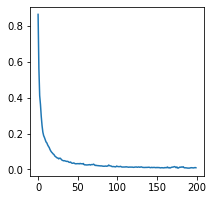

In [42]:
print(d)
plt.plot(train_losses)

In [43]:
pred = predictor(test_data).cpu().data.numpy()
predicted = scaler.invtransform(pred)

In [44]:
predicted.shape, test_out.shape

((100, 3), (100, 3))

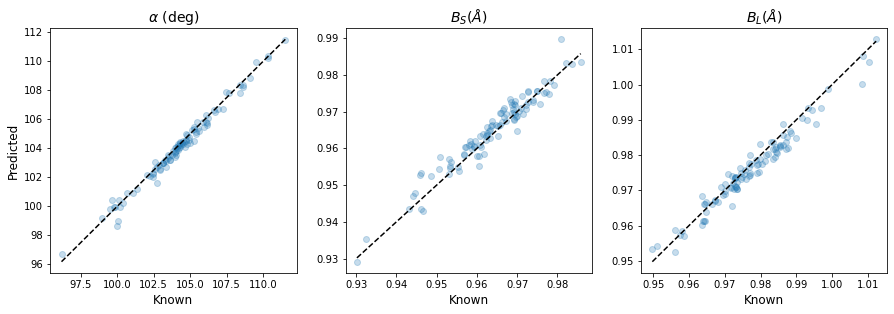

In [46]:
titles = [rf'$\alpha$ (deg)', r'$B_S (\AA)$', r'$B_L (\AA)$']
plt.rcParams['figure.figsize'] = (15, 4.5)
#X = scaler.invtransform(train_out.cpu().data.numpy())
for j in range(3):
    plt.subplot(1,3,j+1)
    x = test_out[:, j]
    #x = X[:, j]
    y = predicted[:, j]
    plt.scatter(x, y, alpha=0.25)
    plt.plot([x.min(), x.max()], [x.min(), x.max()], 'k--')
    plt.title(titles[j], fontsize=14)
    plt.xlabel('Known', fontsize=12)
    if j == 0:
        plt.ylabel('Predicted', fontsize=12)
#plt.savefig(f'{path}/predicted_lowt_{N}_tolowt.png', bbox_inches='tight', dpi=300)